In [3]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=3, linewidth=120)
import DKEFModels
from Datasets import *
import seaborn as sns
import pandas as pd
from Utils import get_grid

%matplotlib inline

## datasets
To fit to different toy datasets listed in the paper, change `dname` to one of the following  
`funnel`, `banana`, `ring`, `uniform`, `cosine`,`grid`, `multiring`

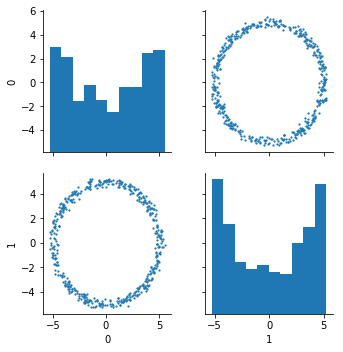

In [4]:
seed = 12
noise_std = 0.0
dname = "ring"
p = load_data(dname, D=2, valid_thresh=0.0, noise_std = noise_std, seed=seed, itanh=False)
D = p.D
    
plot_size=8
ngrid = 100

data = p.data[:500,:5]
df = pd.DataFrame(data)
sns.pairplot(df,  plot_kws=dict(s=5, alpha=1.0, linewidth=0))

## parameters
`npoint`: number of inducing points  
`nlayer`: number of layers in the network  
`init_log_lam`: initial value of regularization strengths  
`init_log_sigma`: the bandwidth for the top Gaussian kernel in each kernel mixture component  
`points_type`: "opt" for inducing points to be optimized, or "fixed"  
`step_size`: optimizer step size  
`base`: whether or not to use Gaussian base measure  
`noise_std`: additive Gaussian noise added to each minibatch  
`init_weight_std`: random initialization of network weights  
`niter`: upper bound of number of iterations  
`ntrain`: size of $\mathcal{D}_{t}$  
`nvalid`: size of $\mathcal{D}_{v}$  
`patience`: how many minibatches to wait for improvement  
`seed`: random seed for weight initialization  
`final_ntrain`: batch size for accumulating statistics for tuning $\lambda$'s   
`final_niter`: number of iterations for tuning $\lambda$'s using all training data   
`final_step_size`: step size for tuning $\lambda$'s  
`gpu_count`: 1 for using GPU, 0 for not  
`curve_penalty`: penalty introduced by Kingma and LeCun (2010)  
`add_skip`: add skip layer from data to last layer of the network  

In [5]:
dl_model = DKEFModels.DeepLite(p, npoint=200, nlayer=3, nneuron=15, 
                               init_log_lam=-2, init_log_sigma=np.logspace(0,1,1),
                               points_type="opt", step_size=1e-2, base=True, noise_std=0.0, init_weight_std=1.0,
                               niter=5000, ntrain=100, nvalid=100, patience=200, seed=0,
                               final_ntrain = 100, final_nvalid=100, final_niter = 1000, final_step_size=1e-3,
                               gpu_count=1, curve_penalty=True, add_skip=True)
kernel_res, alpha_res, logZ = dl_model.fit(0)

trainining kernel:  13%|▏| 636/5001 [02:40<12:38,  5.76it/s[{'test': '-11.819', 'loss': '-11.736'}]]


INFO:tensorflow:Restoring parameters from ckpts/R_D02_l3_nd15_np200_nt100_nv100_pto_ss100_ni5000_n00_k10_m0_b1_p200_nk1_cl0_cu1_q1_s00.ckpt


accumulating stats:  20%|████████▎                                 | 16/81 [00:00<00:00, 151.36it/s]

best score: -11.81857


fitting lambda: 100%|███████████████████████████████████████████| 1000/1000 [00:18<00:00, 54.99it/s]


final validation score: -11.867


## evaluate log likelihood
`n`: number of samples for importance sampling

In [6]:
ll = dl_model.eval(p.test_data, n=10**7).mean()
print ll

estimating logZ: 100%|███████████████████████████████████████| 10000/10000 [00:40<00:00, 245.00it/s]


-3.286118497777258


## see the evalution of parameters

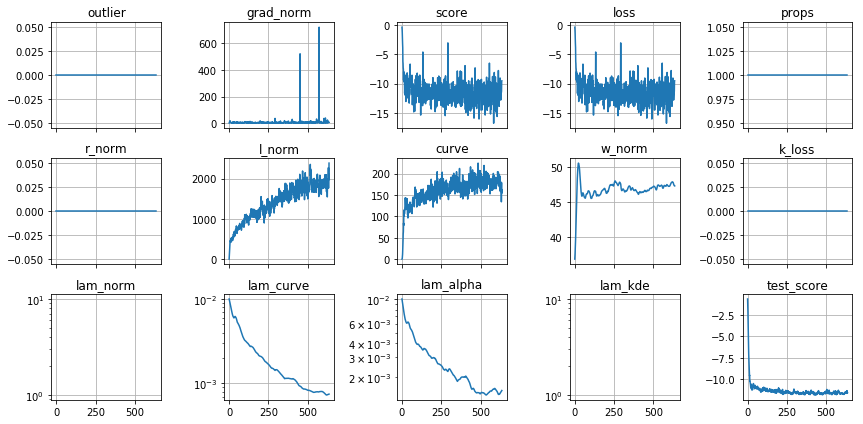

In [8]:
fig, axes = plt.subplots(3,5,figsize=(12,6), sharex=True)

axes = axes.flatten()
res = dl_model.state_hist

for ki, k in  enumerate(res):
    ax = axes[ki]
    ax.plot(res[k])
    ax.set_title(k)
    if "lam" in k: 
        ax.set_yscale("log")
    ax.grid("on")

fig.tight_layout()

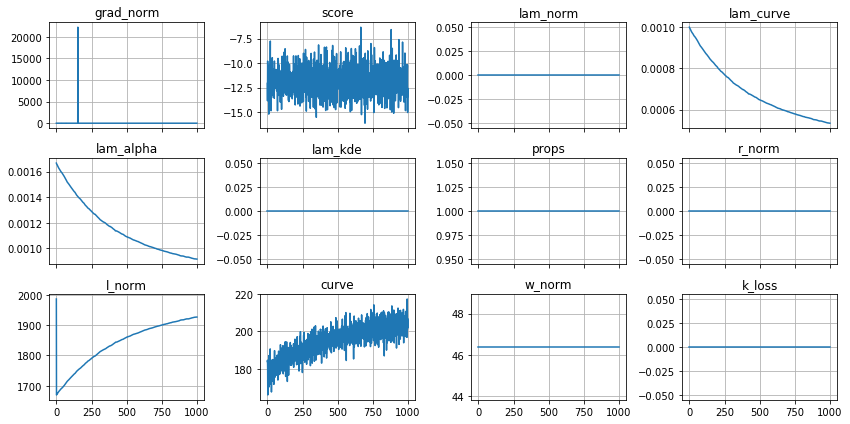

In [9]:
fig, axes = plt.subplots(3,4,figsize=(12,6), sharex=True)
axes = axes.flatten()
res = dl_model.final_state_hist
for ki, k in  enumerate(res):
    ax = axes[ki]
    ax.plot(res[k])
    ax.set_title(k)
    ax.grid("on")

fig.tight_layout()

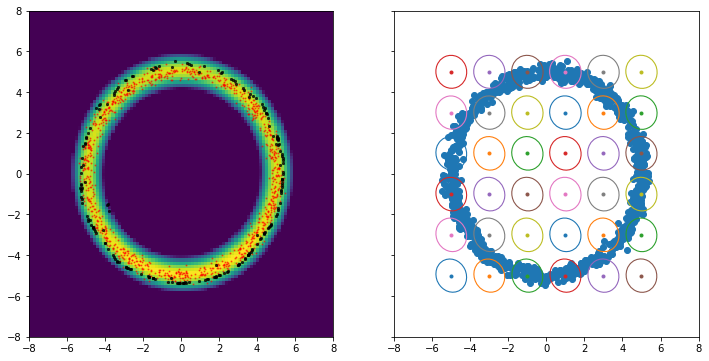

In [10]:
idx_i, idx_j = 0,1

ngrid = 100
eval_grid = np.linspace(-8,8,ngrid)

cond_values = np.zeros(p.D)
epsilon = 1.5

eval_points = get_grid(eval_grid, idx_i, idx_j, cond_values)


logpdf = dl_model.fun_multiple(eval_points)
logpdf -= logpdf.max()

fig, axes = plt.subplots(1,2, figsize=(12,6), sharex=True, sharey=True)

ax = axes[0]
points_val = dl_model.sess.run(dl_model.points)
ax.pcolor(eval_grid, eval_grid, logpdf.reshape(ngrid, ngrid), vmin=-9)
ax.scatter(p.data[:1000,idx_i], p.data[:1000,idx_j], 1, color="r", alpha=0.5)
ax.scatter(points_val[:1000,idx_i], points_val[:1000,idx_j], 5, color="k", alpha=0.8, vmin=1, marker="x")
#ax.quiver(eval_grid[::gint], eval_grid[::gint], gv[::gint,::gint,0], gv[::gint,::gint,1], scale=500)

dim = range(p.D)
dim.remove(idx_i)
dim.remove(idx_j)
#idx_in_range = np.all( (p.test_data[:,dim]<cond_values[dim]+epsilon) &  (p.test_data[:,dim]>cond_values[dim]-epsilon), axis=1)
#data_in_range = p.test_data[idx_in_range]

#plt.scatter(data_in_range[:,i], data_in_range[:,j], 15, color="b")

ax.set_xlim(eval_grid.min(),eval_grid.max())

ax.set_ylim(eval_grid.min(),eval_grid.max())


ax = axes[1]
grid_points = get_grid(np.linspace(-5,5,6), idx_i,idx_j,np.zeros(p.D))
grid_data_one=np.linspace(-8,8,100)
grid_data   = get_grid(grid_data_one, idx_i,idx_j,np.zeros(p.D))

for ki in range(len(dl_model.ops["kernel_grams"])):
    
    kernel_vals = dl_model.sess.run(dl_model.ops["kernel_grams"][ki], feed_dict={dl_model.test_points: grid_points, dl_model.test_data: grid_data})

    for i in range(kernel_vals.shape[0]):
        kv = kernel_vals[i]
        ax.contour(grid_data_one, grid_data_one, kv.reshape(100,100), [0.9], vmin=kv.min(), vmax=kv.max(), colors="C%d"%(i%9), linewidths=[(0.1*(ki+1)**2+1)])
        ax.plot(grid_points[i,idx_i], grid_points[i,idx_j], ".",  color="C%d"%(i%9))
ax.scatter(p.test_data[:,idx_i], p.test_data[:,idx_j])